# Benchmarking Asymmetric Greedy Search (AGS) vs. Linear Sum Assignment (LSA)
This example evaluates the performance and scalability of a the heuristic optimization algorithm, Asymmetric Greedy Search (AGS), against the optimal linear_sum_assignment (LSA) solver from SciPy. The task is formulated as a linear sum assignment problem on distance matrices, where each row (sample) is assigned to a unique column (grid point) to minimize total cost (distance).

## Problem Setup
For each test case:

* A synthetic 2D dataset is generated using make_classification (with 3 classes) and uniform noise.
* Points are assigned to a fixed-size grid_size × grid_size 2D grid via Euclidean distance minimization.
* This produces a (n_samples, grid_size²) distance matrix for assignment.

## Methods Compared
Five methods are benchmarked:
* lsa: SciPy’s linear_sum_assignment (exact solver)
* numpy_ags_default: AGS (NumPy backend, default row-wise greedy updates)
* numpy_ags_batched: AGS (NumPy backend, row batch size = 5)
* numba_ags_default: AGS (Numba-accelerated backend, default)
* numba_ags_batched: AGS (Numba backend, batched row updates)

All AGS variants include optional row shuffling during initialization.

## Experimental Design
* Grid sizes vary from 16×16 to 224×224 in steps of 16
* The number of features is 2/3 the grid space 
* Each configuration is repeated 3 times with different random seeds



In [1]:
import os
os.environ["NUMBA_NUM_THREADS"] = "4"

In [2]:
from asymmetric_greedy_search import AsymmetricGreedySearch
from scipy.optimize import linear_sum_assignment

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.datasets import make_classification
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
from tqdm.notebook import tqdm
import time
import random

In [3]:
numpy_ags = AsymmetricGreedySearch(backend="numpy")
numba_ags = AsymmetricGreedySearch(backend="numba")

test_methods = {
    'lsa': linear_sum_assignment,
    'numpy_ags_default': partial(numpy_ags.optimize, minimize=True, shuffle=True),
    'numpy_ags_batched': partial(numpy_ags.optimize, row_batch_size=5, minimize=True, shuffle=True),
    'numba_ags_default': partial(numba_ags.optimize, minimize=True, shuffle=True),
    'numba_ags_batched': partial(numba_ags.optimize, row_batch_size=5, minimize=True, shuffle=True),
}

test_dims = list(range(16, 224+1, 16))

In [4]:
def class2grid_dist(n_samples, grid_size, random_state=None):
    n_noise = min(100, int(n_samples * 0.9))
    n_class = n_samples - n_noise
    X_class, _ = make_classification(n_samples=n_class, n_features=2, n_redundant=0, 
                                     n_informative=2, n_clusters_per_class=1, n_classes=3,
                                     random_state=random_state)
    # Get min/max bounds from blob data
    x_min, x_max = X_class[:, 0].min(), X_class[:, 0].max()
    y_min, y_max = X_class[:, 1].min(), X_class[:, 1].max()
    # Uniform noise samples (10%)
    np.random.seed(random_state)
    X_noise = np.random.uniform(low=(x_min, y_min), high=(x_max, y_max), size=(n_noise, 2))
    # Combine blob + noise data
    X = np.vstack([X_class, X_noise]).astype(np.float32)
    # Create an n x n grid of centroids
    n = grid_size  # 10x10 grid
    x_grid = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), n)
    y_grid = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), n)
    xx, yy = np.meshgrid(x_grid, y_grid)
    centroids = np.stack([xx.ravel(), yy.ravel()], axis=1).astype(np.float32)  # shape: (n*n, 2)
    # Compute Euclidean distances from each point to each grid centroid
    dist_matrix = cdist(X, centroids, metric="euclidean").astype(np.float32)
    return X, dist_matrix

In [5]:
def measure_time_discretization(matrix, method):
    """Measure the time taken to update the discretization method."""
    start_time = time.time()
    r, a = method(matrix)
    return matrix[r,a].sum(), time.time() - start_time

def time_discretization_with_pool(matrix, method, timeout=60):
    """Measure the time to apply a discretization method with a timeout constraint."""
    with mp.Pool(1) as pool:
        async_result = pool.apply_async(measure_time_discretization, (matrix, method))
        try:
            return async_result.get(timeout)
        except:
            return -1, -1

def measure_time_with_timeout(task):
    """Execute and measure the time taken for a discretization task with timeout handling."""
    fold, method_name, dims, matrix_seed, method, timeout = task
    n = int(dims*dims*2/3)
    _, matrix = class2grid_dist(n, dims, random_state=matrix_seed)
    return (fold, method_name, dims, *(time_discretization_with_pool(matrix, method, timeout)))

def get_timings(tasks, timeout=10):
    """Measure and collect timing data for various discretization methods across 
    pixel sizes."""
    # add timeout to tasks
    tasks = [(task + (timeout,)) for task in tasks]
    timings = []
    with ProcessPoolExecutor(max_workers=5) as executor:
        for fold, method, dims, score, timing in tqdm(executor.map(measure_time_with_timeout, tasks), 
                                                      total=len(tasks), bar_format='{l_bar}{bar:50}{r_bar}'):
            timings.append((fold, method, dims, score, timing))
    return pd.DataFrame([{'fold': fold, 'method': method, 'dims': dims, 'score': score, 'timing': timing}
                         for fold, method, dims, score, timing in timings])


## Visualizing Sample Data and Grid Structure
The plot below shows a 2D scatter of 1,536 synthetic data points generated using a mixture of informative clusters and uniform noise. The overlaid dashed lines represent the regular grid of target centroids (in this case, a 48 × 48 grid) to which points will be assigned in the optimization task. These gridlines correspond to the structure used to compute the Euclidean distance matrix for the assignment problem.

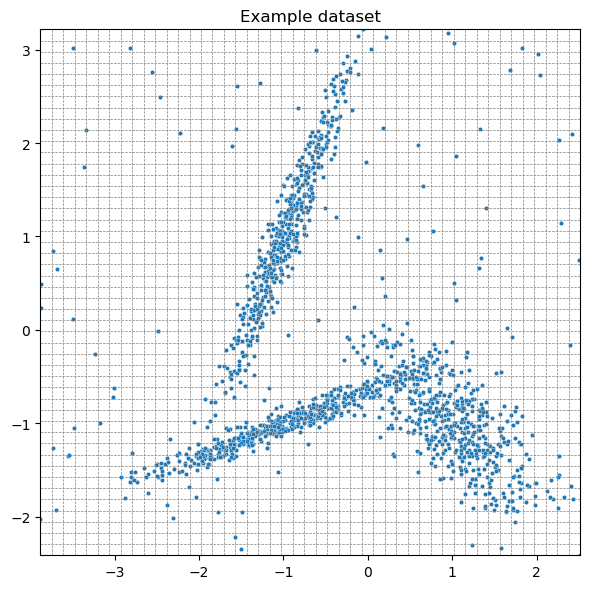

In [24]:
# Generate dataser
n = 48
n_samples = int(n*n*2/3)
X, _ = class2grid_dist(n_samples, n, random_state=5)

# Recalculate the grid lines to match the dist matrix
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
x_grid = np.linspace(x_min, x_max, n)
y_grid = np.linspace(y_min, y_max, n)

# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], s=10, color="tab:blue")

# Add grid lines
for x in x_grid:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
for y in y_grid:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

plt.title("Example dataset")
plt.tight_layout()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

## Benchmark Task Setup
To evaluate and compare the performance of five assignment solvers—including `linear_sum_assignment` (Hungarian method) and both NumPy and Numba backends of the Asymmetric Greedy Search (AGS) algorithm—we generate randomized test cases across a range of matrix sizes. Each case uses a synthetic distance matrix computed between clustered 2D points and a regular grid.

* For each matrix size, 3 repetitions are run with different random seeds to capture variation.
* In total, 5 methods × 14 sizes × 3 repeats = **210 benchmark tasks**.
* Tasks are shuffled to avoid ordering bias and executed in parallel, **5 at a time**.
* A **timeout of 1 hour** is enforced per task to safely handle slow or non-completing methods.
* Numba-based AGS runs are limited to **4 threads** using the `NUMBA_NUM_THREADS=4` environment setting for consistency.

This setup provides a robust and fair comparison of algorithm performance across diverse problem scales.

In [7]:
num_repeats=3
tasks = []
for r in range(num_repeats):
    for dim in test_dims:
        dist_state = np.random.randint(1e5)
        for method_name in test_methods.keys():
            tasks.append((r, method_name, dim, dist_state, test_methods[method_name]))
random.shuffle(tasks)
len(tasks)

210

In [8]:
timings  = get_timings(tasks, timeout=3600)

  0%|                                                  | 0/210 [00:00<?, ?it/s]

In [10]:
timings[timings.timing > 0].sort_values(['dims', 'fold', 'method'])

,fold,method,dims,score,timing
75,0,lsa,16,36.964611,0.001324
196,0,numba_ags_batched,16,37.542706,11.208542
206,0,numba_ags_default,16,37.762589,9.791965
94,0,numpy_ags_batched,16,38.435356,0.038733
124,0,numpy_ags_default,16,38.435356,0.139374
...,...,...,...,...,...
197,0,numba_ags_default,224,26810.955078,1234.193767
116,1,numba_ags_batched,224,39351.097656,801.932505
145,1,numba_ags_default,224,39355.726562,1188.416344
22,2,numba_ags_batched,224,42774.546875,1354.549116


## Timing Performance Plots

In [11]:
def plot_timings(timings):
    """Plot the timing results of discretization methods for different pixel sizes."""
    timings = timings[timings.timing > 0].groupby(['method', 'dims']).mean().reset_index()
    fig, axs = plt.subplots(1,2, figsize=(10, 3), sharex=True, layout='constrained')
    sns.lineplot(data=timings, x='dims', y='timing', hue='method', marker='o', ax=axs[0], legend=False)
    sns.lineplot(data=timings, x='dims', y='timing', hue='method', marker='o', ax=axs[1])
    axs[1].set_yscale("log")
    axs[1].set_ylabel(None)
    handles, labels = axs[1].get_legend_handles_labels()
    axs[1].get_legend().remove()
    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), frameon=False)

The results from the benchmark tasks are summarized and visualized below. Each method's average runtime is plotted across increasing matrix dimensions:

* **Left plot**: Linear scale to observe performance trends on smaller problem sizes.
* **Right plot**: Logarithmic scale to compare scalability across all sizes.

Only successful runs are included.

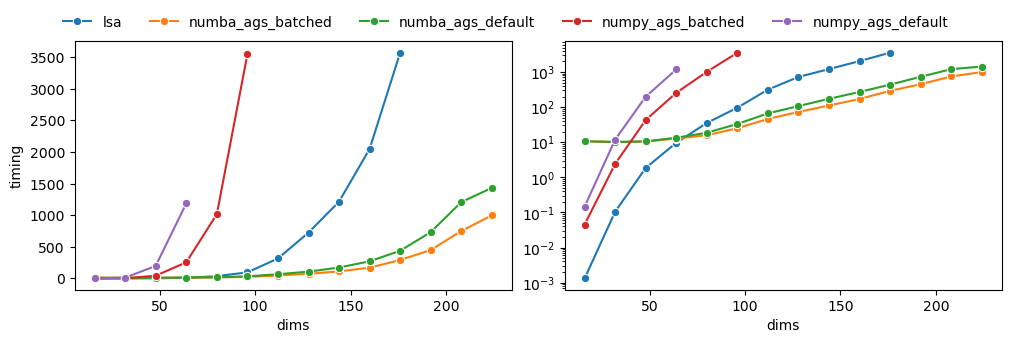

In [12]:
plot_timings(timings)

These results show that **AGS with Numba and batching** is both efficient and scalable for large, dense assignment problems. `lsa` yields exact solutions but quickly becomes computationally expensive beyond 128×128 grids for data of this structure. 

## Conclusion
All methods were evaluated using the same point-to-grid assignment problem, with the goal of minimizing total Euclidean distance. The `lsa` method serves as the reference, producing the optimal solution.

For the AGS (Asymmetric Greedy Search) heuristics, all methods consistently achieved scores **within 1–2% of the optimal** `lsa` solution across all tested grid sizes.

Despite being heuristic and orders-of-magnitude faster, the AGS methods produce high-quality solutions that are nearly indistinguishable from the optimal, making them well-suited for large-scale problems where exact algorithms become computationally prohibitive.

